<a href="https://colab.research.google.com/github/inesNeji/project1/blob/main/SmartChallengeFakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the zip file that contain the data


In [3]:
!unzip '/content/smart-24.zip'

Archive:  /content/smart-24.zip
  inflating: test_data.csv           
  inflating: train_data.csv          


## Import packages


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

## Load and process the train data from the CSV file

In [ ]:


# Load the training and test datasets
train_df = pd.read_csv('/content/train_data.csv')
test_df = pd.read_csv('/content/test_data.csv')

# Preprocessing: Text data and labels
texts_train = train_df['text'].values
labels_train = train_df['label'].values
texts_test = test_df['text'].values

# TF-IDF Vectorizer for the ML models
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(texts_train).toarray()
X_test_tfidf = tfidf.transform(texts_test).toarray()  # Transform test data using the same vectorizer
y_train = labels_train

X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=42)



Logistic Regression Accuracy: 0.9039
Random Forest Accuracy: 0.9029
SVM Accuracy: 0.9029
Naive Bayes Accuracy: 0.8596
KNN Accuracy: 0.7635


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:27:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Model Training (ML & DL)

In [ ]:
# Dictionary of ML models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear'),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")
    return results

# Evaluate basic machine learning models including XGBoost
ml_results = evaluate_models(models, X_train, X_val, y_train, y_val)


In [62]:
max_words = 10000
max_sequence_length = 200

# Tokenizer for text data (for LSTM)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
X_seq = tokenizer.texts_to_sequences(texts)
X_padded = pad_sequences(X_seq, maxlen=max_sequence_length)

# Split the padded data into training and test sets for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Define the LSTM model
def create_lstm_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length),
        LSTM(128, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# EarlyStopping callback for LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the LSTM model
lstm_model = create_lstm_model()
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, validation_data=(X_test_lstm, y_test_lstm),
               batch_size=32, callbacks=[early_stopping])

# Evaluate the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"LSTM Model Accuracy: {lstm_accuracy:.4f}")

# Combine results from traditional models and LSTM
ml_results["LSTM"] = lstm_accuracy

# Print final comparison
print("\nComparison of Model Accuracies:")
for model_name, accuracy in ml_results.items():
    print(f"{model_name}: {accuracy:.4f}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6902 - loss: 0.5387 - val_accuracy: 0.8522 - val_loss: 0.3294
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9381 - loss: 0.1713 - val_accuracy: 0.8965 - val_loss: 0.2375
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9785 - loss: 0.0699 - val_accuracy: 0.8807 - val_loss: 0.3101
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9894 - loss: 0.0366 - val_accuracy: 0.8849 - val_loss: 0.4000
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9923 - loss: 0.0219 - val_accuracy: 0.8838 - val_loss: 0.4509
LSTM Model Accuracy: 0.8965

Comparison of Model Accuracies:
Logistic Regression: 0.9039
Random Forest: 0.9029
SVM: 0.9029
Naive Bayes: 0.8596
KNN: 0.7635
XGBoost: 0.9187
LSTM: 0.8965


In [60]:

import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping



# Define the GRU model
def create_gru_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length),
        GRU(128, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the GRU model
gru_model = create_gru_model()
gru_model.fit(X_train_lstm, y_train_lstm, epochs=20, validation_data=(X_test_lstm, y_test_lstm),
               batch_size=32, callbacks=[early_stopping])

# Evaluate the GRU model
gru_loss, gru_accuracy = gru_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"GRU Model Accuracy: {gru_accuracy:.4f}")



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7194 - loss: 0.5169 - val_accuracy: 0.8881 - val_loss: 0.2523
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9474 - loss: 0.1427 - val_accuracy: 0.8923 - val_loss: 0.2718
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9837 - loss: 0.0521 - val_accuracy: 0.8807 - val_loss: 0.3492
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9945 - loss: 0.0236 - val_accuracy: 0.8807 - val_loss: 0.4112
GRU Model Accuracy: 0.8881


## Plotting The Evaluation metrics of each model


Logistic Regression:
Accuracy: 0.9039
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       450
           1       0.90      0.92      0.91       497

    accuracy                           0.90       947
   macro avg       0.90      0.90      0.90       947
weighted avg       0.90      0.90      0.90       947



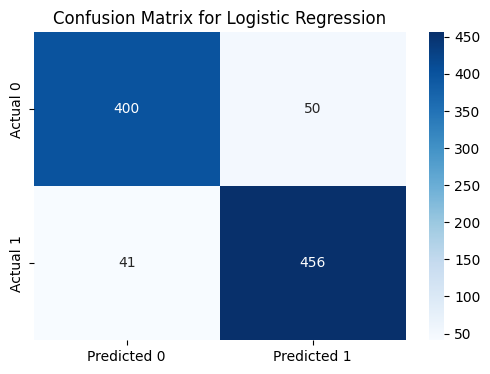


Random Forest:
Accuracy: 0.9029
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       450
           1       0.89      0.93      0.91       497

    accuracy                           0.90       947
   macro avg       0.90      0.90      0.90       947
weighted avg       0.90      0.90      0.90       947



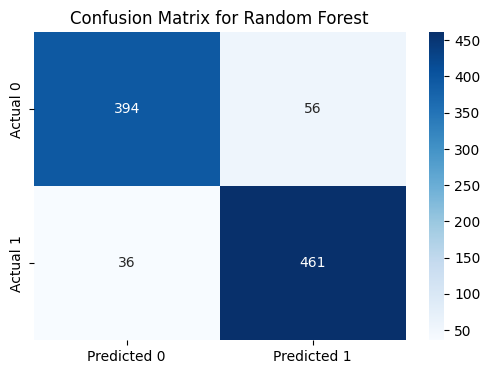


SVM:
Accuracy: 0.9029
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       450
           1       0.91      0.90      0.91       497

    accuracy                           0.90       947
   macro avg       0.90      0.90      0.90       947
weighted avg       0.90      0.90      0.90       947



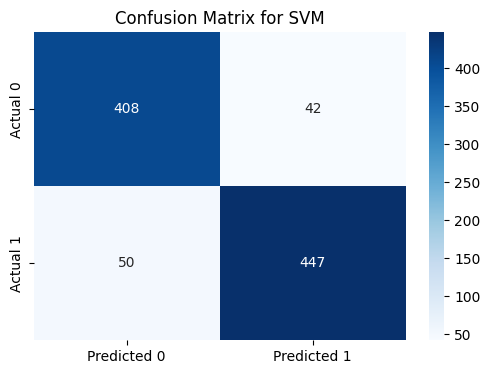


Naive Bayes:
Accuracy: 0.8596
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85       450
           1       0.85      0.90      0.87       497

    accuracy                           0.86       947
   macro avg       0.86      0.86      0.86       947
weighted avg       0.86      0.86      0.86       947



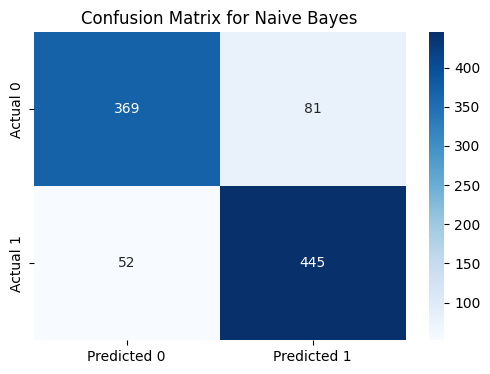


KNN:
Accuracy: 0.7635
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.74      0.75       450
           1       0.77      0.78      0.78       497

    accuracy                           0.76       947
   macro avg       0.76      0.76      0.76       947
weighted avg       0.76      0.76      0.76       947



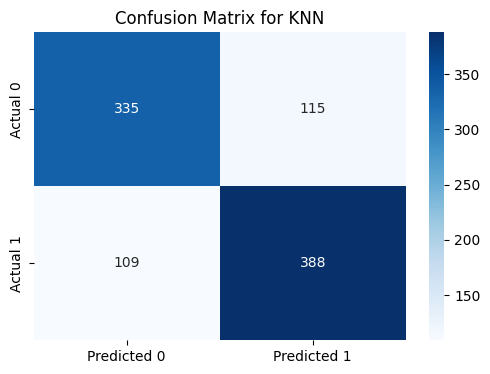

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:19:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost:
Accuracy: 0.9187
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91       450
           1       0.93      0.92      0.92       497

    accuracy                           0.92       947
   macro avg       0.92      0.92      0.92       947
weighted avg       0.92      0.92      0.92       947



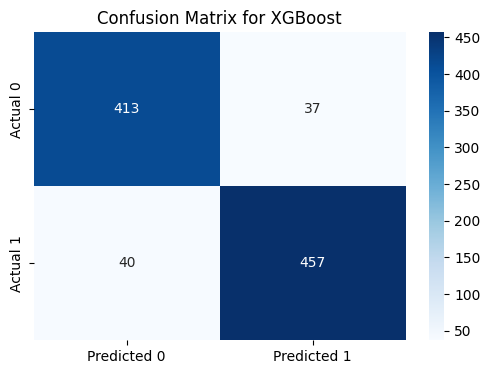

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

LSTM Model:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       450
           1       0.94      0.89      0.92       497

    accuracy                           0.91       947
   macro avg       0.91      0.92      0.91       947
weighted avg       0.92      0.91      0.91       947



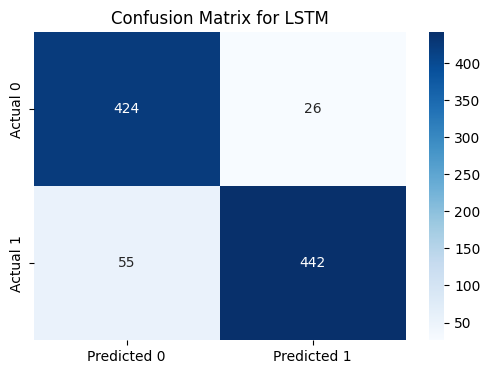

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

GRU Model:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       450
           1       0.89      0.91      0.90       497

    accuracy                           0.89       947
   macro avg       0.89      0.89      0.89       947
weighted avg       0.89      0.89      0.89       947



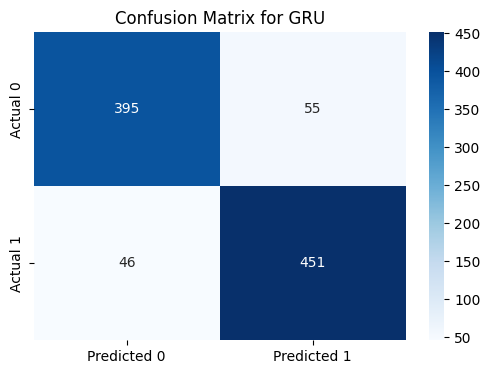

In [55]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"\n{name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f"Confusion Matrix for {name}")
        plt.show()
    return results

ml_results = evaluate_models(models, X_train, X_test, y_train, y_test)

y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)
print(f"\nLSTM Model:")
print("Classification Report:\n", classification_report(y_test_lstm, y_pred_lstm))

cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f"Confusion Matrix for LSTM")
plt.show()

y_pred_gru = (gru_model.predict(X_test_lstm) > 0.5).astype(int)
print(f"\nGRU Model:")
print("Classification Report:\n", classification_report(y_test_lstm, y_pred_gru))

cm_gru = confusion_matrix(y_test_lstm, y_pred_gru)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gru, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f"Confusion Matrix for GRU")
plt.show()
